In [47]:
from google.colab import drive 
import torch 
import torch.nn as nn 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
drive.mount('/gdrive',force_remount = True)
data_path = '/gdrive/My Drive/data.csv' 
data = pd.read_csv(data_path)


Mounted at /gdrive


In [3]:
def preprocessing_onehotencoding(dataframe):
  index = list(set(dataframe.values)) 
  for i in range(len(index)):
    key = index[i]
    boollist = (dataframe == key).values
    T = torch.FloatTensor(boollist)*(i+1)
    if i ==0:
      result = T
    else:
      result += T
  return result

In [48]:
col = list(data.columns)
col1 = col[:5]
col2 = col[5:]
data_Tensor = []
for j in col1:
  data_Tensor.append(preprocessing_onehotencoding(data[j])) #onehotencoding하는 함수
for k in col2:
  T = torch.FloatTensor(data[k].values)
  data_Tensor.append(T)

data_Tensor = torch.stack(data_Tensor, dim=0).transpose(0,1) 

data = data_Tensor[:,:10] #(1000,10)
label = data_Tensor[:,-1].unsqueeze(-1) #(1000,1)

std = torch.std(data, dim=0)
mean = torch.mean(data, dim=0)
# print(mean.shape, std.shape)
ablationhigh = np.zeros((10,10))
ablationlow = np.zeros((10,10))
for i in range(10):
  ablationhigh[i,i] = 1
  ablationlow[i,i] = -1

data = (data-mean)/std
data_Tensor = torch.cat([data, label],dim=-1)



train_data_label, test_data_label = train_test_split(data_Tensor, test_size=0.1) # 900, 11    100,11
train_data = train_data_label[:,:-1]
train_label = train_data_label[:,-1].unsqueeze(1) 

test_data = test_data_label[:,:-1]
test_label =test_data_label[:,-1].unsqueeze(1)



[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
torch.Size([900, 10]) torch.Size([900, 1]) torch.Size([100, 10]) torch.Size([100, 1])


In [13]:
class Classifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.function1= nn.Linear(10,64)
    self.function2= nn.Linear(64,1)
  def forward(self,x):
    tmp = torch.tanh(self.function1(x))
    result = self.function2(tmp)
    return torch.sigmoid(result)

epo 0 : 0.7141916155815125
epo 50 : 0.24298198521137238
epo 100 : 0.1548747569322586
epo 150 : 0.10697127133607864
(20,) (20,)


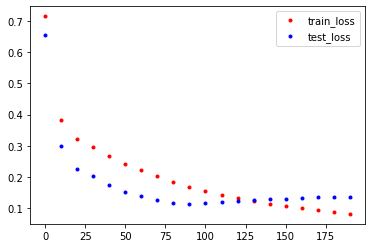

In [14]:
lr = 0.01
epoch = 200

model = Classifier()
optim = torch.optim.Adam(model.parameters(),lr=lr)
L = nn.BCELoss() # 함수는 그냥 L()
losses = []
test_losses = []
epochs = []
for epo in range(epoch):
  optim.zero_grad()
  y_pred = model(train_data)
  loss = L(y_pred,train_label)
  loss.backward()
  optim.step()
  if epo%10 == 0:
    losses.append(loss.detach().numpy())
    test_pred = model(test_data)
    test_loss = L(test_pred, test_label)
    test_losses.append(test_loss.detach().numpy())
    epochs.append(epo)

  if epo%50==0: #epo중에 1000으로 나눠지면 로스 프린트
    print(f'epo {epo} : {loss}')
print(np.asarray(losses).shape, np.asarray(test_losses).shape)
plt.plot(np.asarray(epochs),np.asarray(losses),'r.',label='train_loss')
plt.plot(np.asarray(epochs),np.asarray(test_losses),'b.',label='test_loss')
plt.legend()

In [53]:
model.eval()
test_pred = model(test_data)
test_pred = torch.round(test_pred)
print(test_pred.shape)
tp, tn, fp, fn = 0,0,0,0
for i in range(test_pred.shape[0]):
  if test_pred[i] and test_label[i]:
    tp+=1
  elif test_pred[i] and not test_label[i]:
    fp+=1
  elif not test_pred[i] and test_label[i]:
    fn +=1
  else:
    tn +=1
print(tp,fp,fn,tn)
precision = tp/(tp+fp)
recall = tp/(tp+fn)
accuracy = torch.sum(torch.round(test_pred) == test_label)
print("accuracy : ",(tp+tn), " %")
print("recall", tp/(tp+fn))
print("precision", tp/(tp+fp))
print("f1 : ", (2*recall*precision)/(precision+recall))


print("ablation Study : influence of each element of data")
col_name = ["type_school", "school_accreditation", "gender", "interest","residence","parant_age","parent_salary","house_area","average_grades","parent_was_in_college"]
for i in range(10):
  print( col_name[i], "low : ", float(model(torch.Tensor(ablationlow[i]))), "high : ",float(model(torch.Tensor(ablationhigh[i]))))


torch.Size([100, 1])
57 2 0 41
accuracy :  98  %
recall 1.0
precision 0.9661016949152542
f1 :  0.9827586206896551
ablation Study : influence of each element of data
type_school low :  0.38450905680656433 high :  0.10309204459190369
school_accreditation low :  0.16974279284477234 high :  0.6877800822257996
gender low :  0.5216309428215027 high :  0.29743510484695435
interest low :  0.6045006513595581 high :  0.9591832160949707
residence low :  0.013734935782849789 high :  0.9595187306404114
parant_age low :  0.004894770681858063 high :  0.3061669170856476
parent_salary low :  0.0008249382954090834 high :  0.9952172040939331
house_area low :  0.033688705414533615 high :  0.9852956533432007
average_grades low :  0.2682076096534729 high :  0.9876722097396851
parent_was_in_college low :  0.10567519813776016 high :  0.8415181636810303
